# ML Test for Canditates (2024) - Classification

## Objective

Make a predictive model for electricity consumption

## Task

An energy supplier provides electricity to it's customers in the Canton of Zurich. The customers are mainly businesses, offices and small industries. In order to buy the energy in the wholesale electricity market at the day before the delivery, the supplier needs to predict the total consumption of it's customers. 

The prediction takes place in the morning of every day and the next day's consumption needs to be forecasted.
For example on **17.09.2023 08:00** we need to forecast the consumption from **18.09.2023 00:00 - 19.09.2023 00:00**

The data available at the moment the prediction takes place are:
- the weather forecasts for the next day (you can assume the forecast is perfect for this excersise)
- the consumption of these customers up until the midnight of this day (eg. on **17.09.2023 08:00** the consumption up until **17.09.2023 00:00** is already known)

## Dataset

A dataset with the following columns:
- `datetime_utc_from`: Datetime in UTC (the beginning of the hour)
- `consumption_MWh`: The total electricity consumption of the energy supplier's customers (MWh)
- `temperature_celsius`: Average temperature in the Canton of Zurich (°C)
- `global_radiation_J`: Average solar radiation in the Canton of Zurich (J)

## Binder link

https://mybinder.org/v2/gh/VassilisSaplamidis/interview_tasks_quant/main

## Step 0: Load neccesary libraries

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


## Step 1: Feature engineering

### What would be good features to use for this prediction?
- Does temperature affect the electricity consumption patterns?
- Does the amount of sun affect the electricity consumption patterns?
- The customers are mainly industries and offices. Is there some expectation about their consumption pattern over different days/times of year?
- Can you think of other features that might correlate with the electricity consumption of any given day?

You should create these features now to use them in the model afterwards.

### 1. Load the dataset and set the index to datetime

The dataset is loaded here. Pay attention that the index is UTC time.
We also created a second datetime column that is in the local time zone of the customers, in case you find it useful

In [11]:
# Load the dataset
data = pd.read_csv('data_raw.csv', delimiter=',')
data.set_index('datetime_utc_from', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)
data['datetime_local_from'] = data.index.tz_convert('Europe/Zurich')

### 2. Create categorical features from the dates (DELETE)

In [12]:
# Encode the day-of-week, month columns
data['day_of_week'] = data['datetime_local_from'].dt.day_of_week
data['hour'] = data['datetime_local_from'].dt.hour
data['month'] = data['datetime_local_from'].dt.month

### 3. Create features from the 48h and 7d lagged target (DELETE)

In [13]:
data['consumption_48h_ago'] = data['consumption_MWh'].shift(48)
data['consumption_7d_ago'] = data['consumption_MWh'].shift(24*7)
data.dropna(inplace=True)

## Step 2: Create the dataset for the model

### 1. Split the data into features (X) and target (y)

The target column should be `y = data['consumption_MWh']`

### 2. One-hot encode categorical features (example code)
```
categorical_features = ['feature4', 'feature6']
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_cats, index=X.index, columns=encoder.get_feature_names_out(categorical_features))
X_encoded = pd.concat([X.drop(columns=categorical_features), encoded_df], axis=1)
```

### 3. Any other preprocessing you want 

### 1. Separate features (X) and target (y) (DELETE)

In [14]:
# Split the data into features (X) and target (y)
feature_cols = ['temperature_celsius', 'global_radiation_J', 'consumption_48h_ago', 'consumption_7d_ago', 'day_of_week', 'hour', 'month']
X = data[feature_cols]
y = data['consumption_MWh']

### 2. One-hot encode categorical features (DELETE)

In [15]:
# One-hot encode categorical features
categorical_features = ['day_of_week', 'hour', 'month']
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(X[categorical_features])

# Create a dataframe for the encoded features
encoded_df = pd.DataFrame(encoded_cats, index=X.index, columns=encoder.get_feature_names_out(categorical_features))
X_encoded = pd.concat([X.drop(columns=categorical_features), encoded_df], axis=1)

### 3. Prepare data for the model (DELETE)

In [16]:
# Define the date range for the test set
test_start_date = '2023-10-01'
test_end_date = '2023-10-30'

test_indices = (data.index >= test_start_date) & (data.index <= test_end_date)
train_indices = ~test_indices

X_train = X_encoded[train_indices]
X_test = X_encoded[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

if (X_train.isnull().sum().sum() > 0) or (y_train.isnull().sum() > 0):
    raise ValueError("Training data contains NaN values. Please clean the data before proceeding.")

## Step 3: Model Building

Remember that the goal is to have a good predictive model that is robust and can be used to predict unseen data

### Train the model (DELETE)

In [17]:
# Define the column transformer with scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['temperature_celsius', 'global_radiation_J', 'consumption_48h_ago', 'consumption_7d_ago']),
    ])

# Define the Ridge regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'ridge__alpha': np.logspace(-6, 6, 11),
    'ridge__fit_intercept': [True, False]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

try:
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"Grid search failed: {e}")
    raise

## Step 4: Evaluation

- Can you estimate how good your model performed? 
- Do you think it can be used to predict unseen data? Why? Why not?
- What improvements would you do?

### Evaluation (DELETE)

Best parameters: {'ridge__alpha': 1e-06, 'ridge__fit_intercept': True}
Best cross-validation score: 0.09246372588147184
Test set score: 0.05331894578874621


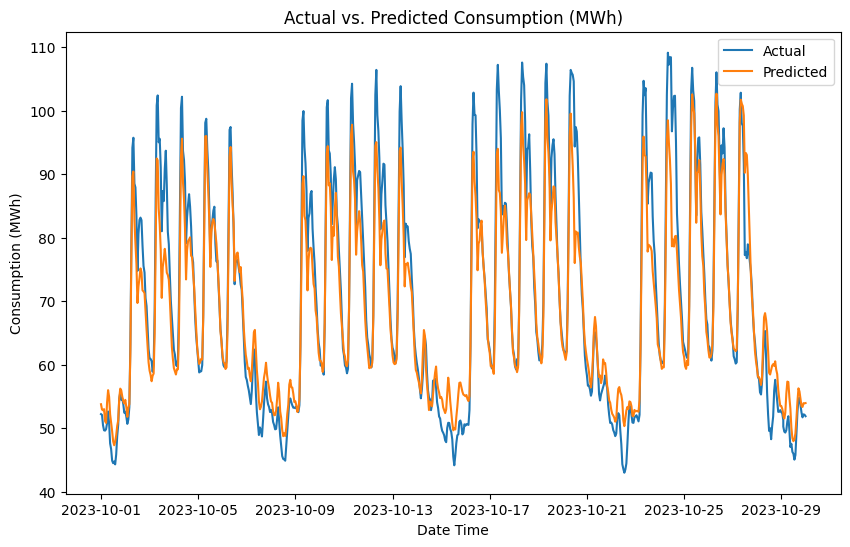

In [18]:
import matplotlib.pyplot as plt

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_}")

# Evaluate the model on the test set
test_score = grid_search.score(X_test, y_test)
print(f"Test set score: {-test_score}")

# Get the predictions for the test set
y_pred = grid_search.predict(X_test)

# Plot the actual values vs. the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')

plt.xlabel('Date Time')
plt.ylabel('Consumption (MWh)')
plt.title('Actual vs. Predicted Consumption (MWh)')
plt.legend()
plt.show()